# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential, load_model
from bayes_opt import BayesianOptimization
from keras.optimizers import Adam
from keras.layers import LSTM, Dense
#from keras.callbacks import EarlyStopping
#from statsmodels.tsa.seasonal import seasonal_decompose
#from hyperopt import fmin, tpe, hp
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import seaborn as sns
import dask.dataframe as dd
from multiprocessing import Pool, cpu_count
#from lstm_helpers import lstm_model
nCores = cpu_count()
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [5]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [6]:
df=pd.read_csv('POWER_Point_Hourly_20010101_20220401_012d0000N_037d2500E_LST.csv', header=13)

In [7]:
# create datetime object
def time_fixer(df):
    datetime_real = (datetime(int(df.loc['YEAR']), int(df.loc['MO']), int(df.loc['DY']), hour=int(df.loc['HR'])))

    return datetime_real

df['datetime'] = dd.from_pandas(df, npartitions = nCores).\
                    map_partitions(
                    lambda data_mini : data_mini.apply(
                    lambda x: time_fixer(x), axis=1)).compute()
df.set_index('datetime', inplace=True)

[########################################] | 100% Completed | 14.06 s
[########################################] | 100% Completed | 14.11 s


In [8]:
# replace null values.
df.ALLSKY_KT.replace(-999, 0, inplace=True)
df.SZA.replace(-999, 90, inplace=True)

# Exploratory Data Analysis

In [9]:
data=df.copy()
data

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,SZA,ALLSKY_KT
datetime,,,,,,,,,,,,,,
2001-01-01 02:00:00,2001,1,1,2,0.00,17.20,6.66,49.81,0.0,81.12,2.81,323.35,90.00,0.00
2001-01-01 03:00:00,2001,1,1,3,0.00,17.48,6.04,46.88,0.0,81.13,1.75,339.95,90.00,0.00
2001-01-01 04:00:00,2001,1,1,4,0.00,17.08,5.70,46.94,0.0,81.17,1.07,25.07,90.00,0.00
2001-01-01 05:00:00,2001,1,1,5,0.00,16.32,5.88,49.94,0.0,81.21,1.43,81.52,90.00,0.00
2001-01-01 06:00:00,2001,1,1,6,87.11,16.82,6.58,50.81,0.0,81.26,2.15,101.31,82.25,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01 19:00:00,2022,4,1,19,0.00,25.53,7.72,32.44,0.0,81.14,4.26,63.76,90.00,0.00
2022-04-01 20:00:00,2022,4,1,20,0.00,24.87,8.48,35.44,0.0,81.20,4.89,63.93,90.00,0.00
2022-04-01 21:00:00,2022,4,1,21,0.00,24.25,9.06,38.38,0.0,81.24,5.63,74.56,90.00,0.00


In [10]:
round(data.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
YEAR,186262.0,2011.13,6.13,2001.00,2006.00,2011.00,2016.00,2022.00
MO,186262.0,6.47,3.46,1.00,3.00,6.00,9.00,12.00
DY,186262.0,15.73,8.80,1.00,8.00,16.00,23.00,31.00
HR,186262.0,11.50,6.92,0.00,6.00,12.00,17.75,23.00
ALLSKY_SFC_SW_DWN,186262.0,251.59,329.33,0.00,0.00,16.58,521.58,1106.36
T2M,186262.0,21.35,3.29,11.55,18.81,20.88,23.62,31.90
T2MDEW,186262.0,11.15,4.05,-8.66,8.33,11.78,14.61,18.83
RH2M,186262.0,55.96,19.24,9.69,40.62,55.62,71.31,94.69
PRECTOTCORR,186262.0,0.16,0.42,0.00,0.00,0.01,0.13,23.28
PS,186262.0,81.27,0.13,80.70,81.18,81.28,81.37,81.78


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186262 entries, 2001-01-01 02:00:00 to 2022-04-01 23:00:00
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   YEAR               186262 non-null  int64  
 1   MO                 186262 non-null  int64  
 2   DY                 186262 non-null  int64  
 3   HR                 186262 non-null  int64  
 4   ALLSKY_SFC_SW_DWN  186262 non-null  float64
 5   T2M                186262 non-null  float64
 6   T2MDEW             186262 non-null  float64
 7   RH2M               186262 non-null  float64
 8   PRECTOTCORR        186262 non-null  float64
 9   PS                 186262 non-null  float64
 10  WS10M              186262 non-null  float64
 11  WD10M              186262 non-null  float64
 12  SZA                186262 non-null  float64
 13  ALLSKY_KT          186262 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 21.3 MB


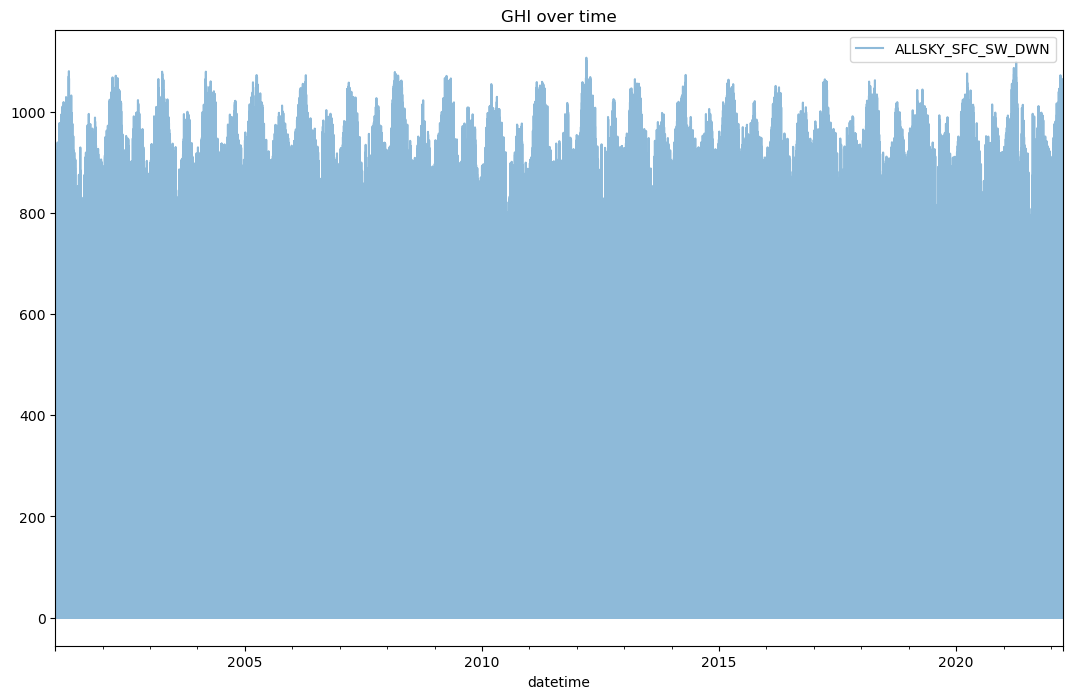

In [12]:
# Irradiance metrics over time
data[['ALLSKY_SFC_SW_DWN']].plot(alpha=.5)
plt.title('GHI over time');

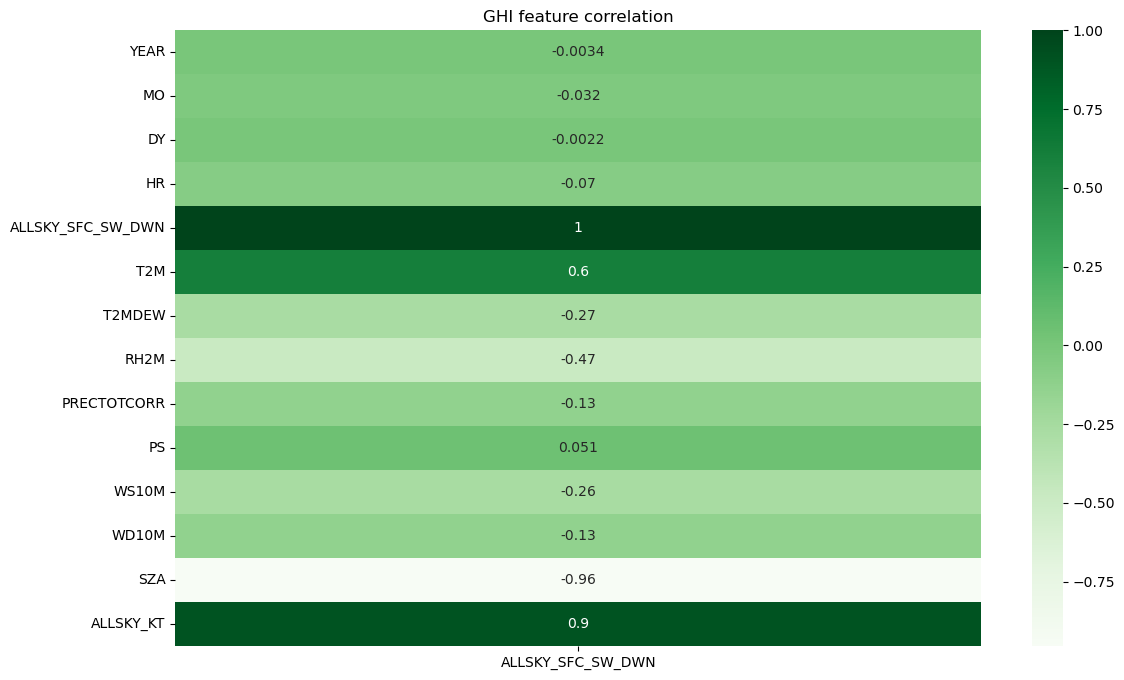

In [13]:
# Feature correlation for irradiance metrics
sns.heatmap(data.corr()[['ALLSKY_SFC_SW_DWN']], cmap='Greens', annot=True)
plt.title('GHI feature correlation');

# Feature Engineering

In [14]:
def create_lagged_features(data, n_lags):
    lagged_data = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        lagged_data[f'lag_{i}'] = data.shift(i)
    return lagged_data.dropna()

# Create up to 5hrs lag for the target feature.
n_lags = 5
lagged_data = create_lagged_features(data['ALLSKY_SFC_SW_DWN'], n_lags)
lagged_data = pd.concat([data, lagged_data], axis=1).dropna()
lagged_data

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,SZA,ALLSKY_KT,lag_5,lag_4,lag_3,lag_2,lag_1
datetime,,,,,,,,,,,,,,,,,,,
2001-01-01 07:00:00,2001,1,1,7,324.49,18.98,5.88,42.38,0.0,81.32,2.59,101.31,69.42,0.66,0.00,0.00,0.00,0.00,87.11
2001-01-01 08:00:00,2001,1,1,8,554.05,21.08,4.45,33.94,0.0,81.35,2.11,80.64,57.37,0.73,0.00,0.00,0.00,87.11,324.49
2001-01-01 09:00:00,2001,1,1,9,738.85,22.44,3.58,29.38,0.0,81.33,1.10,82.22,46.80,0.77,0.00,0.00,87.11,324.49,554.05
2001-01-01 10:00:00,2001,1,1,10,841.14,23.38,2.83,26.25,0.0,81.28,0.22,216.47,38.98,0.77,0.00,87.11,324.49,554.05,738.85
2001-01-01 11:00:00,2001,1,1,11,895.08,24.10,2.98,25.44,0.0,81.22,1.31,259.36,35.74,0.78,87.11,324.49,554.05,738.85,841.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01 19:00:00,2022,4,1,19,0.00,25.53,7.72,32.44,0.0,81.14,4.26,63.76,90.00,0.00,560.27,353.17,152.38,22.98,0.00
2022-04-01 20:00:00,2022,4,1,20,0.00,24.87,8.48,35.44,0.0,81.20,4.89,63.93,90.00,0.00,353.17,152.38,22.98,0.00,0.00
2022-04-01 21:00:00,2022,4,1,21,0.00,24.25,9.06,38.38,0.0,81.24,5.63,74.56,90.00,0.00,152.38,22.98,0.00,0.00,0.00


# Feature Selection

In [ ]:
X=lagged_data.drop('ALLSKY_SFC_SW_DWN', axis=1)
y=lagged_data['ALLSKY_SFC_SW_DWN']

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Select top 10 most contributing features
n_features_to_select = 10
rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)

# Fit the RFE object to the data
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.get_support()]
X = X[selected_features].values

# Normalization and Sequence creation

In [ ]:
y=lagged_data['ALLSKY_SFC_SW_DWN'].values
y=y.reshape(-1, 1)

# Normalize the dataset to the range of 0 to 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Define the window size of the sequence.
window_size = 24

# Create sequences from the data 
sequences_x = []
for i in range(len(X) - window_size):
    sequence = X[i:i + window_size]
    sequences_x.append(sequence)

sequences_y = []
for i in range(len(y) - window_size):
    sequence = y[i:i + window_size]
    sequences_y.append(sequence)

# Split the dataset into Train/Test sets.
split = int(len(sequences_x) * 0.8)

X_tr = np.array(sequences_x[:split])
y_tr = np.array(sequences_y[:split])

X_test = np.array(sequences_x[split:])
y_test = np.array(sequences_y[split:])

# Model design

In [ ]:
# Create the LSTM model
def lstm_model(n_neurons, n_layers, lr, train_index, test_index):
    model = Sequential()
    model.add(LSTM(int(round(n_neurons)), input_shape=(X_tr.shape[1], X_tr.shape[2]), return_sequences=True))
    
    for _ in range(int(round(n_layers)) - 1):
        model.add(LSTM(int(round(n_neurons)), return_sequences=True))
    
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    model.fit(X_tr[train_index], y_tr[train_index], epochs=25, batch_size=32, 
              validation_data=(X_tr[test_index], X_tr[test_index]), verbose=2, shuffle=False)
    
    # Evaluate the model on the test set
    evaluation_metrics = model.evaluate(X_test, y_test)
    
    # Return the trained model and the evaluation metrics
    return evaluation_metrics[1]

# Parallelized time-series cross-validation

In [ ]:
def parallel_cv(data, n_neurons, n_layers):
    # split the train set into 4, each further divided into train and test (3 months) sets.
    tscv = TimeSeriesSplit(n_splits=4, test_size=window_size*90)
    
    results = Parallel(n_jobs=-1)(delayed(lstm_model)(n_neurons, n_layers, 0.001, train_index, test_index)
                             for train_index, test_index in tscv.split(data))
    
    return -np.mean(results)

# Hyperparameter optimization

In [32]:
def optimize_lstm(data, pbounds):
    optimizer = BayesianOptimization(
        f=lambda n_neurons, n_layers: parallel_cv(data, n_neurons, n_layers),
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )
    optimizer.maximize(init_points=5, n_iter=25)
    return optimizer.max


In [33]:
print("Current Time is:", datetime.now())

Current Time is: 2023-06-07 08:15:18.498334


In [ ]:
# Set range of values the optimizer should cover.
bounds = {'n_neurons': (10, 500), 'n_layers': (1, 5)}

best_params = optimize_lstm(X_tr, bounds)


|   iter    |  target   | n_layers  | n_neurons |
-------------------------------------------------


In [ ]:
print("Current Time is:", datetime.now())

In [18]:
print("best parameters:", best_params)

best parameters: {'target': -0.028195494320243597, 'params': {'n_layers': 1.0388673679162368, 'n_neurons': 37.26369349006629}}


In [ ]:
n_layers = int(best_params['params']['n_layers'])
n_neurons = int(best_params['params']['n_neurons'])
model = train_lstm(train_data, test_data, n_layers, n_neurons)

In [10]:
model.save('Best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 158)           106808    
                                                                 
 dense (Dense)               (None, 24, 1)             159       
                                                                 
Total params: 106,967
Trainable params: 106,967
Non-trainable params: 0
_________________________________________________________________


In [11]:
test_scores=model.evaluate(X_test, y_test, batch_size=25, verbose=2)

1490/1490 - 25s - loss: 6.5776e-04 - root_mean_squared_error: 0.0256 - 25s/epoch - 17ms/step


In [23]:
start=datetime.now()
yhat = model.predict(X_test)
end=datetime.now()
print("Total Time taken:", end - start)

1164/1164 [==============================] - 14s 12ms/step
Total Time taken: 0:00:14.111681


# Evaluation results

In [26]:
yhat=yhat.flatten()
y_test=y_test.flatten()
rmse = mean_squared_error(yhat, y_test, squared=False)
rmse

0.025646779100542937

In [27]:
r2_score(y_test, yhat)

0.9924989560419064

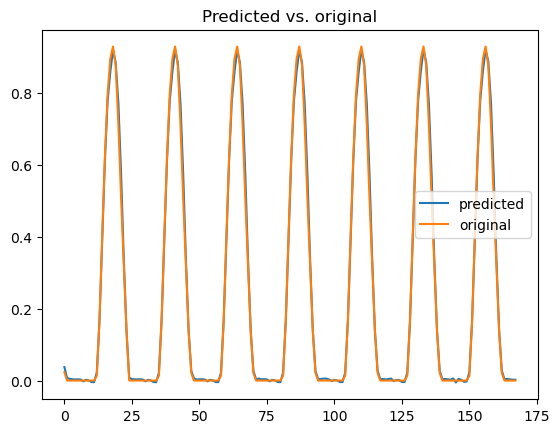

In [28]:
days=7*24
plt.plot(yhat[-days:], label='predicted')
plt.plot(y_test[-days:], label='original')
plt.legend()
plt.title('Predicted vs. original')
    
plt.show()